# AAPL Preprocessing

In [32]:
import numpy as np
import time
import datetime
import pandas as pd
from pandas.tseries.offsets import BMonthEnd
import seaborn as sns
import matplotlib.pyplot as plt

In [33]:
crsp = pd.read_csv('AAPL.csv',index_col='date')
crsp.drop(columns=['PERMNO', 'RETX'], inplace=True)
crsp

,BIDLO,ASKHI,PRC,VOL,RET,OPENPRC
date,,,,,,
1980-12-12,28.75000,28.87500,-28.81250,NaN,C,NaN
1980-12-15,27.25000,27.37500,-27.31250,NaN,-0.052061,NaN
1980-12-16,25.25000,25.37500,-25.31250,NaN,-0.073227,NaN
1980-12-17,25.87500,26.00000,-25.93750,NaN,0.024691,NaN
1980-12-18,26.62500,26.75000,-26.68750,NaN,0.028916,NaN
...,...,...,...,...,...,...
2024-12-24,255.28999,258.20999,258.20001,23146511.0,0.011478,255.49001
2024-12-26,257.63000,260.10001,259.01999,27065955.0,0.003176,258.19000
2024-12-27,253.06000,258.70001,255.59000,42079549.0,-0.013242,257.82999


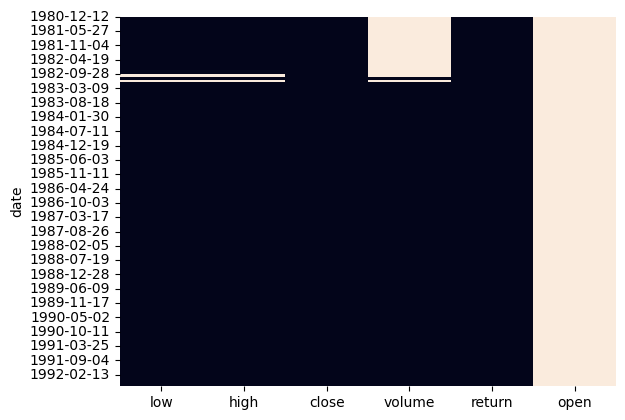

low         43
high        43
close        1
volume     499
return       1
open      2917
dtype: int64

In [34]:
crsp.columns = ['low', 'high', 'close', 'volume', 'return', 'open'] # rename columns 

# plot missing values
sns.heatmap(crsp.iloc[np.unique\
    (np.where(crsp.isnull())[0]),:]\
    .isnull(),cbar=False)
plt.show()

# count number of missing values
crsp.isnull().sum()

In [35]:
# filter data from first date after which there are no missing values
first_valid_date = crsp.notna().all(axis=1).idxmax()
crsp = crsp[crsp.index >= first_valid_date]

# convert all entries to float and make all prices positive
crsp = crsp.map(lambda x: float(x) if x is not None else None)
for col in ['open', 'high', 'low', 'close']:
    crsp[col] = pd.to_numeric(crsp[col], errors='coerce').abs()
crsp

,low,high,close,volume,return,open
date,,,,,,
1992-06-15,52.50000,54.00000,52.62500,1674644.0,-0.036613,54.00000
1992-06-16,48.75000,52.00000,49.25000,3314828.0,-0.064133,51.75000
1992-06-17,47.00000,49.25000,47.50000,2719955.0,-0.035533,49.00000
1992-06-18,44.75000,49.00000,45.25000,3925309.0,-0.047368,47.50000
1992-06-19,43.75000,46.00000,44.75000,3818924.0,-0.011050,46.00000
...,...,...,...,...,...,...
2024-12-24,255.28999,258.20999,258.20001,23146511.0,0.011478,255.49001
2024-12-26,257.63000,260.10001,259.01999,27065955.0,0.003176,258.19000
2024-12-27,253.06000,258.70001,255.59000,42079549.0,-0.013242,257.82999


In [36]:
# Create adjusted close prices using total return
growth = 1.0 + crsp['return']
base_close_raw = crsp['close'].iloc[0]
crsp['close_adj'] = base_close_raw * growth.cumprod()

# Scale open, high, low to preserve ratios to unadjusted close
scale = crsp['close_adj'] / crsp['close'].replace(0, np.nan)
scale = scale.replace([np.inf, -np.inf], np.nan).ffill().fillna(1.0)
crsp['open_adj'] = crsp['open'] * scale
crsp['high_adj'] = crsp['high'] * scale
crsp['low_adj'] = crsp['low'] * scale
crsp

,low,high,close,volume,return,open,close_adj,open_adj,high_adj,low_adj
date,,,,,,,,,,
1992-06-15,52.50000,54.00000,52.62500,1674644.0,-0.036613,54.00000,50.698241,52.022898,52.022898,50.577817
1992-06-16,48.75000,52.00000,49.25000,3314828.0,-0.064133,51.75000,47.446811,49.855278,50.096125,46.965117
1992-06-17,47.00000,49.25000,47.50000,2719955.0,-0.035533,49.00000,45.760883,47.205964,47.446810,45.279190
1992-06-18,44.75000,49.00000,45.25000,3925309.0,-0.047368,47.50000,43.593282,45.760903,47.205984,43.111588
1992-06-19,43.75000,46.00000,44.75000,3818924.0,-0.011050,46.00000,43.111576,44.315810,44.315810,42.148189
...,...,...,...,...,...,...,...,...,...,...
2024-12-24,255.28999,258.20999,258.20001,23146511.0,0.011478,255.49001,34451.127524,34089.537470,34452.459136,34062.849189
2024-12-26,257.63000,260.10001,259.01999,27065955.0,0.003176,258.19000,34560.544305,34449.800319,34704.649318,34375.080585
2024-12-27,253.06000,258.70001,255.59000,42079549.0,-0.013242,257.82999,34102.893577,34401.771235,34517.856370,33765.320430


In [37]:
def Z_from_series(series_adj, close_adj, offset=100.0):
    R = (series_adj / close_adj.shift(1)).replace([np.inf, -np.inf], np.nan)
    R = R.fillna(1.0)
    R = R.clip(lower=1e-12)
    return offset + np.log(R).cumsum()

In [38]:
# Construct Z series
crsp['Z_close'] = Z_from_series(crsp['close_adj'], crsp['close_adj'])
crsp['Z_open'] = Z_from_series(crsp['open_adj'], crsp['close_adj'])
crsp['Z_high'] = Z_from_series(crsp['high_adj'], crsp['close_adj'])
crsp['Z_low'] = Z_from_series(crsp['low_adj'], crsp['close_adj'])

# Volume preprocessing (no split/div adjustment; stabilize with log1p)
crsp['Z_volume'] = np.log1p(pd.to_numeric(crsp['volume'], errors='coerce').fillna(0.0))

In [ ]:
# Sanity checks
# 1) Z_close equivalence to 100 + log(C_adj / C0)
z_close_alt = 100 + np.log(crsp['close_adj'] / crsp['close_adj'].iloc[0])
print("max |Z_close - alt| =", (crsp['Z_close'] - z_close_alt).abs().max())

# 2) adjusted-close pct change should match total return
adj_ret = crsp['close_adj'].pct_change()
print("max |adj_ret - RET| =", np.nanmax(np.abs(adj_ret - crsp['return'])))

max |Z_close - alt| = 1.4210854715202004e-14
max |adj_ret - RET| = 3.3306690738754696e-16


In [40]:
crsp

,low,high,close,volume,return,open,close_adj,open_adj,high_adj,low_adj,Z_close,Z_open,Z_high,Z_low,Z_volume
date,,,,,,,,,,,,,,,
1992-06-15,52.50000,54.00000,52.62500,1674644.0,-0.036613,54.00000,50.698241,52.022898,52.022898,50.577817,100.000000,100.000000,100.000000,100.000000,14.331112
1992-06-16,48.75000,52.00000,49.25000,3314828.0,-0.064133,51.75000,47.446811,49.855278,50.096125,46.965117,99.933718,99.983233,99.988052,99.923514,15.013917
1992-06-17,47.00000,49.25000,47.50000,2719955.0,-0.035533,49.00000,45.760883,47.205964,47.446810,45.279190,99.897538,99.978144,99.988052,99.876752,14.816126
1992-06-18,44.75000,49.00000,45.25000,3925309.0,-0.047368,47.50000,43.593282,45.760903,47.205984,43.111588,99.849012,99.978145,100.019143,99.817114,15.182956
1992-06-19,43.75000,46.00000,44.75000,3818924.0,-0.011050,46.00000,43.111576,44.315810,44.315810,42.148189,99.837900,99.994583,100.035582,99.783403,15.155480
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-24,255.28999,258.20999,258.20001,23146511.0,0.011478,255.49001,34451.127524,34089.537470,34452.459136,34062.849189,106.521406,106.342277,228.270547,-21.267786,16.957355
2024-12-26,257.63000,260.10001,259.01999,27065955.0,0.003176,258.19000,34560.544305,34449.800319,34704.649318,34375.080585,106.524577,106.342239,228.277879,-21.269996,17.113787
2024-12-27,253.06000,258.70001,255.59000,42079549.0,-0.013242,257.82999,34102.893577,34401.771235,34517.856370,33765.320430,106.511246,106.337634,228.276643,-21.293274,17.555072


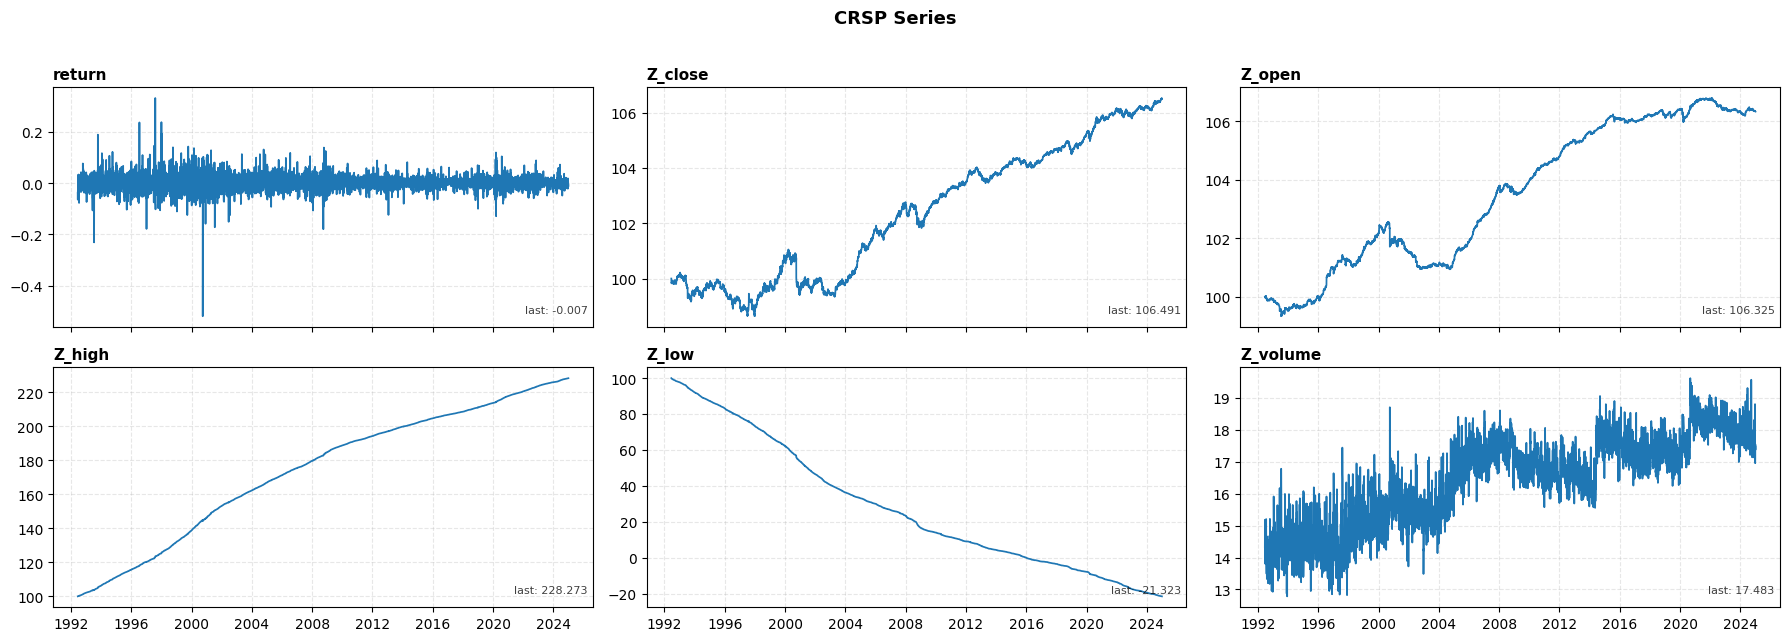

In [47]:
def plot_crsp(crsp, title_prefix="CRSP Series"):
    df = crsp.copy()

    if not isinstance(df.index, pd.DatetimeIndex):
        df.index = pd.to_datetime(df.index, errors="coerce")
    df = df.sort_index()

    candidates = ["return", "Z_close", "Z_open", "Z_high", "Z_low", "Z_volume"]
    cols = [c for c in candidates if c in df.columns]
    n = len(cols)
    ncols = 3 if n <= 6 else 4
    nrows = int(np.ceil(n / ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=(18, 3.2 * nrows), sharex=True)
    axes = np.array(axes).ravel()

    for i, c in enumerate(cols):
        ax = axes[i]
        s = df[c].dropna()
        ax.plot(s.index, s.values, linewidth=1.25)
        ax.set_title(c, loc="left", fontsize=11, fontweight="bold")
        ax.grid(True, linestyle="--", alpha=0.3)
        if len(s):
            ax.text(0.99, 0.05, f"last: {s.iloc[-1]:.3f}",
                    transform=ax.transAxes, ha="right", va="bottom",
                    fontsize=8, alpha=0.75)

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    fig.suptitle(f"{title_prefix}", y=0.995, fontsize=13, fontweight="bold")
    fig.tight_layout(rect=[0, 0, 1, 0.98])
    plt.show()
    
plot_crsp(crsp)

In [48]:
# export crsp
crsp.to_csv('AAPL_preprocessed.csv')